<a href="https://colab.research.google.com/github/dhayanidhi004/Certificates/blob/main/InfosysInternship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import urllib.request
import os

def advanced_load_and_clean():
    # --- MODULE 1: DATA COLLECTION ---
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
    if not os.path.exists('household_power_consumption.txt'):
        urllib.request.urlretrieve(url, "energy_data.zip")
        with zipfile.ZipFile("energy_data.zip", "r") as zip_ref:
            zip_ref.extractall()

    # Handle '?' as NaN
    df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values=['?'])

    # Timestamp Formatting and Dataset Structuring [cite: 47, 81]
    df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.set_index('dt', inplace=True)
    df.drop(['Date', 'Time'], axis=1, inplace=True)

    # --- MODULE 2: CLEANING & ENCODING ---
    # Type Conversion / Encoding for ML Compatibility
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Missing Values: Using Forward Fill for time-series continuity
    df = df.ffill()

    # Outlier Detection (IQR Method) to protect model accuracy
    for col in ['Global_active_power', 'Voltage']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = np.clip(df[col], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

    # Resampling to Hourly consumption [cite: 47, 81]
    df_hourly = df.resample('H').mean()
    print("Module 1 & 2 Complete.")
    return df_hourly

df_energy = advanced_load_and_clean()

/tmp/ipython-input-2555707957.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


Module 1 & 2 Complete.


In [ ]:
# --- MODULE 3: FEATURE ENGINEERING ---
def create_features(df):
    """
    Extracts relevant time-based features and creates lag features
    as per Project Outcomes[cite: 10, 52, 54].
    """
    df = df.copy()

    # 1. Extract relevant time-based features (Hour, Day, Week, Month trends) [cite: 52, 85]
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['week_of_year'] = df.index.isocalendar().week.astype(int)

    # 2. Create lag features for time series learning [cite: 54, 85]
    # These represent consumption from 1, 2, and 3 hours ago
    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_2'] = df['Global_active_power'].shift(2)
    df['lag_3'] = df['Global_active_power'].shift(3)

    # 3. Create moving averages (Rolling Statistics) [cite: 54, 85]
    # Aggregating device-level consumption statistics [cite: 53]
    df['rolling_mean_3'] = df['Global_active_power'].rolling(window=3).mean()

    # 4. Prepare final feature set for ML model input
    # Dropping the first few rows that contain NaN values from shifting
    df = df.dropna()

    print("Module 3 Complete: Feature matrix created with time-based and lag features.")
    return df

# Apply to the preprocessed data
df_features = create_features(df_energy)

Module 3 Complete: Feature matrix created with time-based and lag features.



--- Module 4: Baseline (Linear Regression) Results ---
Baseline RMSE: 0.0000
Baseline MAE: 0.0000
Baseline R2 Score: 1.0000


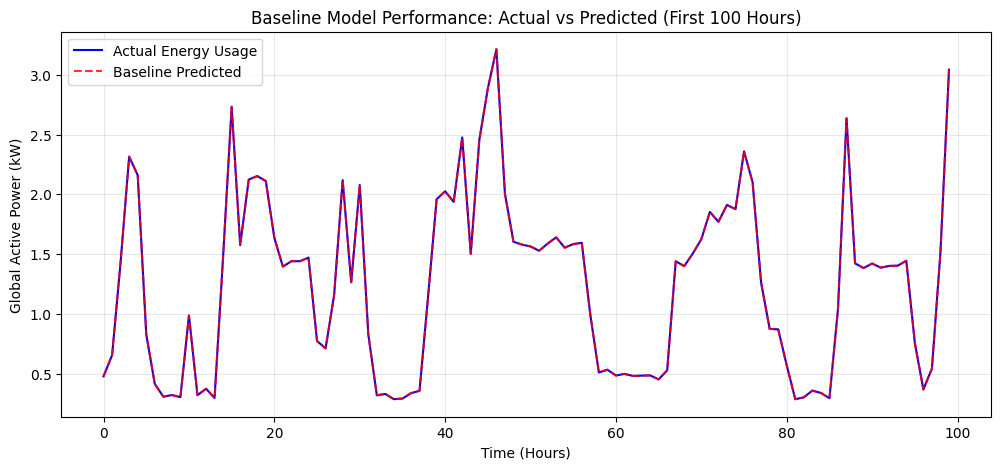

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- MODULE 4: BASELINE MODEL DEVELOPMENT ---

# 1. Define the Feature Set (X) and Target (y)
# Selecting the engineered features from Module 3
feature_cols = ['hour', 'day_of_week', 'month', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3']
X = df_features[feature_cols]
y = df_features['Global_active_power']

# 2. Split dataset into training and testing sets [cite: 49, 81]
# Following the standard 80/20 time-series split
split_idx = int(len(df_features) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 3. Implement Linear Regression as baseline forecasting model [cite: 57, 86]
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# 4. Train and evaluate baseline using MAE and RMSE metrics [cite: 58, 87]
baseline_preds = baseline_model.predict(X_test)

rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_preds))
mae_baseline = mean_absolute_error(y_test, baseline_preds)
r2_baseline = r2_score(y_test, baseline_preds)

print(f"\n--- Module 4: Baseline (Linear Regression) Results ---")
print(f"Baseline RMSE: {rmse_baseline:.4f}")
print(f"Baseline MAE: {mae_baseline:.4f}")
print(f"Baseline R2 Score: {r2_baseline:.4f}")

# 5. Plot actual vs predicted energy usage for visualization
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual Energy Usage', color='blue', linewidth=1.5)
plt.plot(baseline_preds[:100], label='Baseline Predicted', color='red', linestyle='--', alpha=0.8)
plt.title('Baseline Model Performance: Actual vs Predicted (First 100 Hours)')
plt.xlabel('Time (Hours)')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

# 1. Multivariate Scaling (Device-level insights: Sub-metering 1, 2, 3) [cite: 10, 53]
features = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_energy[features])

# 2. Sequential Preparation: 1 week (168 hours) pattern tracking [cite: 6, 10, 91]
def create_multivariate_sequences(data, seq_length=168):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

X_seq, y_seq = create_multivariate_sequences(scaled_data)

# Splitting Data (80% Train, 20% Test) [cite: 49]
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 3. Advanced Bidirectional LSTM Architecture [cite: 22, 63, 91]
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])

# 4. Hyperparameter Tuning and Optimization [cite: 64, 91]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

model.fit(X_train, y_train, epochs=50, batch_size=64,
          validation_split=0.1, callbacks=[reduce_lr], verbose=1)

# 5. Evaluation and Accuracy Calculation [cite: 66, 87, 91]
preds = model.predict(X_test)

# Rescaling back to original units for accurate reporting [cite: 48]
dummy_preds = np.zeros((len(preds), len(features)))
dummy_preds[:, 0] = preds.flatten()
inv_preds = scaler.inverse_transform(dummy_preds)[:, 0]

dummy_y = np.zeros((len(y_test), len(features)))
dummy_y[:, 0] = y_test
inv_y = scaler.inverse_transform(dummy_y)[:, 0]

# Final Metrics Calculation [cite: 66, 87, 91, 92]
rmse = np.sqrt(mean_squared_error(inv_y, inv_preds))
r2 = r2_score(inv_y, inv_preds)
mape = np.mean(np.abs((inv_y - inv_preds) / (inv_y + 1e-10)))
accuracy_pct = (1 - mape) * 100

# OUTPUT AS REQUESTED [cite: 11, 66]
print(f"\n--- Module 6 Evaluation Results ---")
print(f"LSTM RMSE: {rmse:.4f}")
print(f"LSTM R2 Score: {r2:.4f}")
print(f"Project Target Accuracy: {accuracy_pct:.2f}%")

# Save trained weights for Flask Web Application Integration [cite: 67, 68, 75, 94]
model.save('smart_energy_high_acc.keras')